# Práctica de laboratorio: propiedades del YBaCuO

In [2]:
import numpy as np
import matplotlib.pylab as plt
import scipy.optimize as so
import pandas as pd
from decimal import * #para las cifras significativas
from tabulate import tabulate

Leemos los datos obtenidos en el laboratorio y los almacenamos en las dos variables: la temperatura y la resistividad.

In [3]:
data=pd.read_table('datos.txt', delimiter = ';')

In [4]:
T = np.array(data['Temp'],'float')
R_micro = np.array(data['Resistividad'],'float') #la resistividad nos la saca en micro ohm* metro
R = 10**(-6)*R_micro
for i in range(len(R)):
    R[i] += abs(min(R))

Ajustamos la región normal 

In [5]:
#Definimos una función de ajuste:
def reg_lin(x, a, b):
    return a + b*x
#valores iniciales de los parámetros
par = [2 , 0.02]
sol , cov = so.curve_fit(reg_lin, T[72:], R[72:], p0=(par))
#cov = matriz de covarianza , sol = resultados de los parámetros
a = sol[0] #parámetros que mejor se ajustan a los datos
b = sol[1]
sa , sb = np.sqrt(np.diag(cov)) #desviaciones estándar (diagonal de la matriz de covarianza)

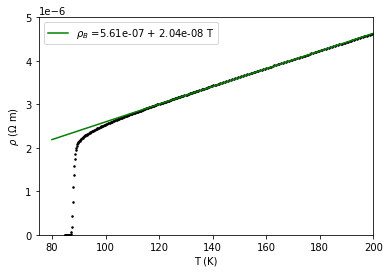

In [8]:
plt.plot(T, R, 'k.', markersize=3)
T_aux = np.linspace(80, 275, 1000)
rho_B_ajuste = a + b*T_aux
plt.plot(T_aux, rho_B_ajuste, 'g-', label=r'$\rho_{B}$ =%.3g + %.3g T ' % (a, b))
#plt.title('Título')
plt.xlabel('T (K)', fontsize=10)
plt.ylabel(r'$\rho$ ($\Omega$ m)', fontsize=10)
plt.xticks(fontsize=10); plt.yticks(fontsize=10)
plt.legend(loc='best', fontsize=10)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlim(75, 200)
plt.ylim(0,5*10**(-6))
#plt.savefig('rhoT.pdf')
plt.show()

#### Temperatura crítica
Determinamos la temperatura crítica mediante dos métodos.

#### 1$^{er}$ método
Ajustamos el último punto de $\rho$ no nulo y los dos anteriores a una recta. El corte con el eje horizontal será la temperatura crítica.

In [9]:
i = 1
while R[i] - R[i-1] < 0.3*10**(-6):
    i += 1
index = i
T_ajuste = [T[index], T[index+1], T[index+2]]
R_ajuste = [R[index], R[index+1], R[index+2]]
sol , cov = so.curve_fit(reg_lin, T_ajuste, R_ajuste)
a_ajuste = sol[0]
b_ajuste = sol[1]

T_C_aux = -a_ajuste/b_ajuste
T_C = T_C_aux + abs(T_C_aux - 88.8)/2
deltaT = abs(T_C - 88.8)/2
print(u"Tc = ({:.2f} \u00B1 {:.2f}) K".format(T_C, deltaT))

Tc = (88.01 ± 0.40) K


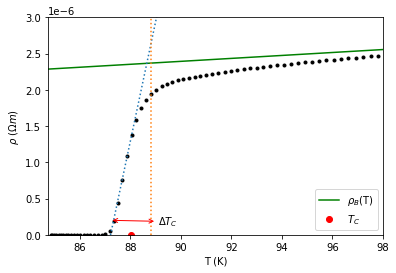

In [10]:
plt.plot(T, R, 'k.')
plt.plot(T_aux, rho_B_ajuste, 'g-', label=r'$\rho_{B}$(T)')
plt.plot(T_aux, a_ajuste+b_ajuste*T_aux, linestyle='dotted')#, label=r'ajuste a $T_{C}$'
aux = np.ones([1000])*88.8
plt.plot(aux, np.linspace(0,10**(-5),1000), linestyle='dotted')
#plt.plot(T_C, 0, 'bo', label=r'$T_{C}$')
plt.plot(T_C, 0, 'ro', label=r'$T_{C}$')
#plt.arrow(T_C, 0.25*10**(-6), abs(T_C - 88.8), 0, head_width = 0.2*10**(-6), width = 0.05*10**(-6))
plt.annotate(r'$\Delta T_{C}$', xy=(T_C_aux, 0.2*10**(-6)), xytext=(T_C+abs(T_C - 89.1), 0.14*10**(-6)), arrowprops=dict(arrowstyle='<->', color='red'))
plt.ylim(0,0.000003)
plt.xlim(84.75,98)
plt.xlabel(r'T (K)')
plt.ylabel(r'$\rho$ ($\Omega m$)')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend(loc='lower right')
#plt.savefig('Tc1.pdf')
plt.show()

#### 2º método
El método que utilizan en el artículo del CV: la temperatura crítica es el punto del eje horizontal correspondiente al punto de máxima pendiente. Representamos la derivada de la resisitividad frente a la temperatura, y el punto del eje horizontal corrrespondiente al máximo será $T_{c}$.

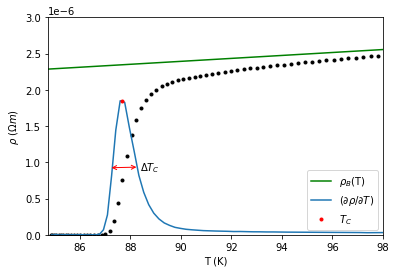

Tc = (87.69 ± 0.41) K


In [69]:
plt.plot(T, R, 'k.')
plt.plot(T_aux, rho_B_ajuste, 'g-', label=r'$\rho_{B}$(T)')
plt.ylim(0,0.000003)
plt.xlim(84.75,98)

derivada = np.diff(R)/np.diff(T)
Rc = max(derivada)
lista = derivada.tolist()
i = lista.index(max(derivada))+1
Tc = T[lista.index(max(derivada))+1]
plt.plot((T[:-1]+T[1:])/2, derivada, label=r'$(\partial \rho/\partial T)$')
plt.plot(Tc, Rc, 'r.', label=r'$T_{C}$')

def gauss(x, c, mu, sigma):
    return c*np.exp(-(x-mu)**2/(2*sigma**2))
par = (1, 87.6, 0.5)
sol_gauss , cov_gauss = so.curve_fit(gauss, T[18:28], derivada[18:28], p0=(par))
c = sol_gauss[0] ; mu = sol_gauss[1] ; sigma = sol_gauss[2]
y1 = gauss(T[18:28], c, mu, sigma)
#plt.plot(T[18:28], y1, linestyle='dotted', color='green')
plt.annotate(r'$\Delta T_{C}$', xy=((mu-1.25*sigma), Rc/2), xytext=((mu+1.75*sigma), Rc/2-3*10**(-8)), arrowprops=dict(arrowstyle='<->', color='red'))

plt.xlabel(r'T (K)')
plt.ylabel(r'$\rho$ ($\Omega m$)')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend(loc='best')
#plt.savefig('Tc2.pdf')
plt.show()
print(u"Tc = ({:.2f} \u00B1 {:.2f}) K".format(Tc, sigma))

### Paraconductividad
Definimos la conductividad debida a las fluctuaciones o paraconductividad ($\sigma_{fl}$) y la representamos frente a la temperatura reducida ($\epsilon$).

In [12]:
#resisitividad del estado normal
rho_B = a + b*T
#definimos la temperatura crítica
#solo nos interesa definir los puntos en los que rho > 0 -> solo trabajamos con temperaturas superiores
#a la que le corresponde al último rho > 0
E = (T[index:]-Tc)/Tc
#definimos la paraconductividad
sigma = 1/R[index:] - 1/rho_B[index:]
#en la región normal, puede ocurrir que el ajuste quede 'por debajo' de los datos experimentales, dando una
#conductividad negativa, lo cual carece de sentido
for i in range(len(sigma)):
    sigma[i] = abs(sigma[i])

Como vimos en teoría (o si nos fijamos en los valores de $\sigma$), solo debemos trabajar en las temperaturas cercanas a $T_{C}$

C:\Users\sergi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\sergi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


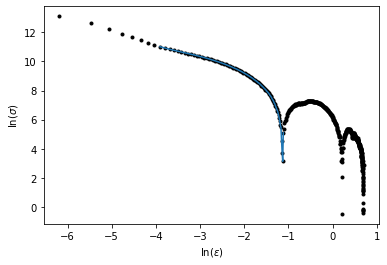

In [53]:
plt.plot(np.log(E), np.log(sigma), 'k.')
plt.xlabel(r'$\ln(\epsilon)$')
plt.ylabel(r'$\ln(\sigma)$')
#cuanto menor sea ln(epsilon), implica que T será más cercana a Tc -> solo trabajamos con los primeros valores
indices = []
for i in range(len(E)):
    if np.log(E[i]) > -4 and np.log(E[i]) < -1.1:
        indices.append(i)
index_min = min(indices)
index_max = max(indices)

sigma_aux = sigma[index_min:index_max]
E_aux = E[index_min:index_max]
plt.plot(np.log(E_aux), np.log(sigma_aux))
plt.show()

### Modelado de la paraconductividad
Realizamos el ajuste a los 3 marcos teóricos para obtener $\xi(0)$ y comprobar el exponente de $\epsilon$

#### 1. Modelo sin correcciones:

$$\sigma_{fl} = \frac{e^{2}}{32\hbar\xi(0)} \epsilon^{-1/2}\quad \Rightarrow \quad \ln(\sigma_{fl}) = \ln\left(\frac{e^{2}/32\hbar}{\xi(0)}\right) -\frac{1}{2} \ln(\epsilon)$$

In [54]:
#definimos la función de ajuste
def paraconduct_lin(x, e, pend):
    cte = ((1.602*10**(-19))**2)/(32*1.05*10**(-34))
    return np.log(cte/e) - pend*x
#como el modelo solo predice la primera zona (lineal), sol calculamos la pendiente en esa zona.
#que el ajuste no concuerda con los datos ya se comprueba en la representación gráfica.
j = 0
while abs(np.log(E_aux[j])) > 2.5 :
    indices.append(j)
    j += 1    
indice_max = j
param_in = (10**(-10), 0.5)
sol , cov = so.curve_fit(paraconduct_lin, np.log(E_aux[:indice_max]), np.log(sigma_aux[:indice_max]), p0=(param_in))
E_0 = sol[0]
deltaE = np.sqrt(cov[0][0])
pendiente = sol[1]
delta_pendiente = np.sqrt(cov[1][1])
print(pendiente)
print(delta_pendiente)
print('-------------')
print(E_0)
print(deltaE)

0.7789616810081386
0.010013563133263022
-------------
2.6101795411864295e-09
8.19116812614894e-11


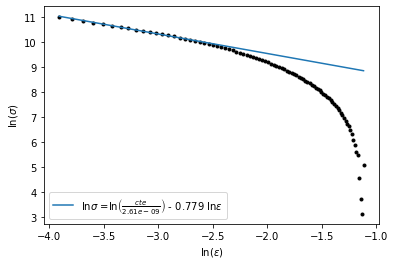

In [55]:
plt.plot(np.log(E_aux), np.log(sigma_aux), 'k.')
plt.plot(np.log(E_aux), paraconduct_lin(np.log(E_aux), E_0, pendiente), label=r'$\ln\sigma$ =$\ln \left(\frac{cte}{%.3g}\right)$ - %.3g $\ln\epsilon$ ' % (E_0, pendiente))
plt.xlabel(r'$\ln(\epsilon)$')
plt.ylabel(r'$\ln(\sigma)$')
plt.legend(loc='lower left')
#plt.savefig('sincutoff.pdf')
plt.show()

##### Análisis adicional: tendencias del exponente de $\epsilon$

Como vimos en la teoría, el YBCO se comporta como una mezcla entre un SC tridimensional y un bidimensional, es decir, el exponente de $\epsilon$ no es estrictamente ni -1/2 (3D) ni -1 (2D) . Por ello, podemos hacer el ajuste lineal a varias regiones de los datos.

In [56]:
### REXIÓN 1
j = 0
while abs(np.log(E_aux[j])) > 3.25:
    j += 1    
indice_max1 = j
param_in = (10**(-10), 0.5)
sol1 , cov1 = so.curve_fit(paraconduct_lin, np.log(E_aux[:indice_max1]), np.log(sigma_aux[:indice_max1]), p0=(param_in))
E_01 = sol1[0]
deltaE1 = np.sqrt(cov1[0][0])
pendiente1 = sol1[1]
delta_pendiente1 = np.sqrt(cov1[1][1])
print('Rexión 1:')
print('Expoñente = ', pendiente1)
print('Incerteza = ', delta_pendiente1)
print('-------------')

### REXIÓN 2
j = 0
while abs(np.log(E_aux[j])) > 2:
    j += 1
indice_max2 = j
param_in = (10**(-10), 0.5)
sol2 , cov2 = so.curve_fit(paraconduct_lin, np.log(E_aux[indice_max1:indice_max2]), np.log(sigma_aux[indice_max1:indice_max2]), p0=(param_in))
E_02 = sol2[0]
deltaE2 = np.sqrt(cov2[0][0])
pendiente2 = sol2[1]
delta_pendiente2 = np.sqrt(cov2[1][1])
print('Rexión 2:')
print('Expoñente = ', pendiente2)
print('Incerteza = ', delta_pendiente2)

Rexión 1:
Expoñente =  0.7321060378231169
Incerteza =  0.009729759806569972
-------------
Rexión 2:
Expoñente =  1.0688355063067247
Incerteza =  0.023210664037096755


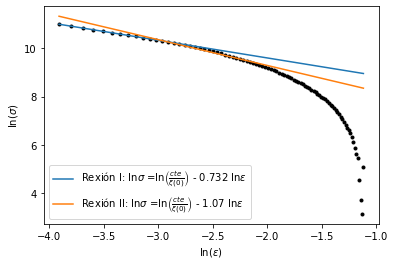

In [57]:
plt.plot(np.log(E_aux), np.log(sigma_aux), 'k.')
plt.plot(np.log(E_aux), paraconduct_lin(np.log(E_aux), E_01, pendiente1), label=r'Rexión I: $\ln\sigma$ =$\ln \left(\frac{cte}{\xi (0)}\right)$ - %.3g $\ln\epsilon$ ' % (pendiente1))
plt.plot(np.log(E_aux), paraconduct_lin(np.log(E_aux), E_02, pendiente2), label=r'Rexión II: $\ln\sigma$ =$\ln \left(\frac{cte}{\xi (0)}\right)$ - %.3g $\ln\epsilon$ ' % (pendiente2))
plt.xlabel(r'$\ln(\epsilon)$')
plt.ylabel(r'$\ln(\sigma)$')
plt.legend(loc='lower left')
plt.savefig('rexions.pdf')
plt.show()

#### 2. Modelo con cut-off en energía cinética:
$$\sigma_{fl} = \frac{e^{2}}{16\hbar\pi\xi(0)} \left[ \frac{\arctan\left(\sqrt{\frac{c}{\epsilon}}\right)}{\sqrt{\epsilon}} - \frac{\sqrt{c}}{\epsilon + c} \right] \quad \Rightarrow \quad \ln \sigma_{fl} = \ln\left( \frac{e^{2}/16\hbar\pi}{\xi(0)}\right) + \ln\left[ \frac{\arctan\left(\sqrt{\frac{c}{\epsilon}}\right)}{\sqrt{\epsilon}} - \frac{\sqrt{c}}{\epsilon + c} \right]  $$

In [61]:
#definimos la función de ajuste
def paraconduct_cin(x, e, c):
    cte = ((1.602*10**(-19))**2)/(16*np.pi*1.05*10**(-34))
    return np.log(cte/e) + np.log(((np.arctan(np.sqrt(c/x)))/(np.sqrt(x)))-((np.sqrt(c))/(x+c)))
param_in = (10**(-10), 0.5)
sol, cov = so.curve_fit(paraconduct_cin, E_aux[:indice_max], np.log(sigma_aux[:indice_max]), p0=(param_in))
E_0_cin = sol[0]
deltaE_cin = np.sqrt(cov[0][0])
c_cin = sol[1]
print(E_0_cin)
print(deltaE_cin)

6.497688656929691e-10
6.155927251475026e-12


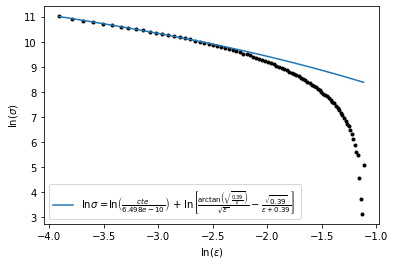

In [62]:
plt.plot(np.log(E_aux), np.log(sigma_aux), 'k.')
plt.plot(np.log(E_aux), paraconduct_cin(E_aux, E_0_cin, c_cin), label=r'$\ln\sigma$ =$\ln \left(\frac{cte}{%.4g}\right)$ + $\ln \left[ \frac{\arctan\left(\sqrt{\frac{%.2g}{\epsilon}}\right)}{\sqrt{\epsilon}} - \frac{\sqrt{%.2g}}{\epsilon + %.2g} \right]$ ' % (E_0_cin, c_cin, c_cin, c_cin))
plt.xlabel(r'$\ln(\epsilon)$')
plt.ylabel(r'$\ln(\sigma)$')
plt.legend(loc='lower left')
#plt.savefig('cutoffcin.pdf')
plt.show()

#### 3. Modelo con cut-off en energía total:
$$\sigma_{fl} = \frac{e^{2}}{16\hbar\pi\xi(0)} \left[ \frac{\arctan\left(\sqrt{\frac{c-\epsilon}{\epsilon}}\right)}{\sqrt{\epsilon}} - \frac{\sqrt{c-\epsilon}}{c} \right] \quad \Rightarrow \quad \ln \sigma_{fl} = \ln\left( \frac{e^{2}/16\hbar\pi}{\xi(0)}\right) + \ln\left[ \frac{\arctan\left(\sqrt{\frac{c - \epsilon}{\epsilon}}\right)}{\sqrt{\epsilon}} - \frac{\sqrt{c-\epsilon}}{c} \right]$$

In [63]:
#definimos la función de ajuste
def paraconduct_tot(x, e, c):
    cte = ((1.602*10**(-19))**2)/(16*np.pi*1.05*10**(-34))
    return np.log(cte/e) + np.log(((np.arctan(np.sqrt(abs(c-x)/x))/(np.sqrt(x)))-((np.sqrt(c-x))/(c))))
param_in = (10**(-10), 0.5)
sol, cov = so.curve_fit(paraconduct_tot, E_aux, np.log(sigma_aux), p0=(param_in))
E_0_tot = sol[0]
deltaE_tot = np.sqrt(cov[0][0])
c_tot = sol[1]
print(E_0_tot)
print(deltaE_tot)

5.428854680564409e-10
1.6175752094315605e-11


C:\Users\sergi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


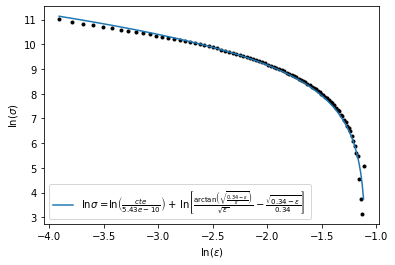

In [64]:
plt.plot(np.log(E_aux), np.log(sigma_aux), 'k.')
plt.plot(np.log(E_aux), paraconduct_tot(E_aux, E_0_tot, c_tot), label=r'$\ln\sigma$ =$\ln \left(\frac{cte}{%.3g}\right)$ + $\ln\left[ \frac{\arctan\left(\sqrt{\frac{%.2g-\epsilon}{\epsilon}}\right)}{\sqrt{\epsilon}} - \frac{\sqrt{%.2g-\epsilon}}{%.2g} \right]$ ' % (E_0_tot, c_tot, c_tot, c_tot))
plt.xlabel(r'$\ln(\epsilon)$')
plt.ylabel(r'$\ln(\sigma)$')
plt.legend(loc='lower left')
#plt.savefig('cutofftot.pdf')
plt.show()

### Comparación de los 3 modelos:

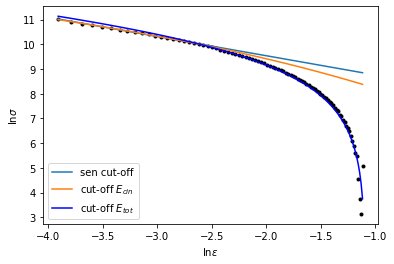

In [66]:
plt.plot(np.log(E_aux), np.log(sigma_aux), 'k.')
plt.plot(np.log(E_aux), paraconduct_lin(np.log(E_aux), E_0, pendiente), label=r'sen cut-off')
plt.plot(np.log(E_aux), paraconduct_cin(E_aux, E_0_cin, c_cin), label=r'cut-off $E_{cin}$ ')
plt.plot(np.log(E_aux), paraconduct_tot(E_aux, E_0_tot, c_tot), 'b-', label=r'cut-off $E_{tot}$')
plt.xlabel(r'$\ln\epsilon$')
plt.ylabel(r'$\ln\sigma$')
plt.legend(loc='lower left')
#plt.savefig('completo.pdf')
plt.show()

In [279]:
resultados = [['sin cut-off', '{:0.3e}'.format(E_0), '{:0.1e}'.format(deltaE)],
['cut-off Ecin', '{:0.3e}'.format(E_0_cin), '{:0.1e}'.format(deltaE_cin)],
['cut-off Etot', '{:0.3e}'.format(E_0_tot), '{:0.1e}'.format(deltaE_tot)]]

print (tabulate(resultados, headers=["modelo", u"\u03BE (m)", u"u(\u03BE)"], tablefmt='fancy_grid'))

╒══════════════╤═══════════╤═════════╕
│ modelo       │     ξ (m) │    u(ξ) │
╞══════════════╪═══════════╪═════════╡
│ sin cut-off  │ 2.961e-09 │ 1.2e-10 │
├──────────────┼───────────┼─────────┤
│ cut-off Ecin │ 6.372e-10 │ 9e-12   │
├──────────────┼───────────┼─────────┤
│ cut-off Etot │ 5.375e-10 │ 1.7e-11 │
╘══════════════╧═══════════╧═════════╛
